In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import model
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM
from keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
#read dataset
df = pd.read_csv('/content/gdrive/MyDrive/dataset/Sentence pairs in English-Malay - 2021-11-06.tsv', sep='\t')
df

,code,english,code.1,malay
0,1277,I have to go to sleep.,720364,Saya harus pergi tidur.
1,1326,Are you sure?,974220,Adakah anda pasti?
2,1337,"When I grow up, I want to be a king.",720366,Saya ingin menjadi seorang raja apabila saya menjadi dewasa.
3,1430,I will play Sudoku then instead of continuing to bother you.,960957,Elok saya bermain Sudoku dan tidak mengganggu anda lagi.
4,1666,I have lost my wallet.,372563,Dompet saya sudah hilang.
...,...,...,...,...
2631,6738350,The mason will build the house.,10367863,Tukang batu akan membina rumah.
2632,7214462,Tom told me that he plans on doing that.,10365522,Tom memberitahu saya bahawa dia merancang untuk melakukan itu.
2633,10456074,Muhammad is quite fond of eating watermelon at home.,10456077,Muhammad ini cukup suka makan tembikai di rumah.
2634,7737408,I know lots of guitar players.,10489134,Saya tahu ramai pemain gitar.


In [ ]:
#perform eda
df.columns

Index(['code', 'english', 'code.1', 'malay'], dtype='object')

In [ ]:
df.shape

(2636, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   code     2636 non-null   int64 
 1   english  2636 non-null   object
 2   code.1   2636 non-null   int64 
 3   malay    2636 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.5+ KB


In [ ]:
df.isnull().sum()

code       0
english    0
code.1     0
malay      0
dtype: int64

In [ ]:
#load needed data
data = df.iloc[:,[1,3]].values

In [ ]:
#Remove punctuation from the data
data[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,0]]
data[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,1]]
data

array([['I have to go to sleep', 'Saya harus pergi tidur'],
       ['Are you sure', 'Adakah anda pasti'],
       ['When I grow up I want to be a king',
        'Saya ingin menjadi seorang raja apabila saya menjadi dewasa'],
       ...,
       ['Muhammad is quite fond of eating watermelon at home',
        'Muhammad ini cukup suka makan tembikai di rumah'],
       ['I know lots of guitar players', 'Saya tahu ramai pemain gitar'],
       ['So I tried seaweed for the first time in a while and it was actually pretty good Hey in Japan we eat at the dinner table a lot Is it less common in the US Its common in most families but my family doesnt really do it',
        'Pertama kali saya sudah cuba makan rumpai laut dan ia memang lazat Di Jepun kami banyak makan di meja makan Adakah ia lebih kurang daripada di Amerika Syarikat Biasanya kebanyakan keluarga tapi keluarga saya tidak pasti pun']],
      dtype=object)

In [ ]:
#change all the sentence to lower case
for i in range (len(data)):
  data[i,0] = data[i,0].lower()
  data[i,1] = data[i,1].lower()

In [ ]:
#tokenize the data
en = []
ms = []

for i in data[:,0]:
  en.append(len(i.split()))
for i in data[:,1]:
  ms.append(len(i.split()))

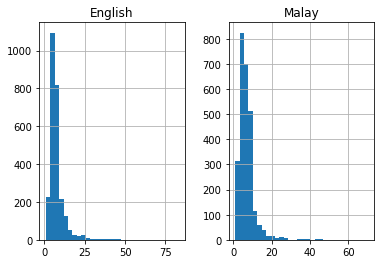

In [ ]:
#check length
length_df = pd.DataFrame({'English':en, 'Malay':ms})

length_df.hist(bins = 30)
plt.show()

In [ ]:
max(ms)

70

In [ ]:
#contruct a tokenizer function
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
#tokenize the en data
en_tokenizer = tokenization(data[:, 0])
en_vocab_size = len(en_tokenizer.word_index) + 1

en_length = 70
print('English Vocabulary Size: %d' % en_vocab_size)

English Vocabulary Size: 2959


In [ ]:
#tokenize the ms data
ms_tokenizer = tokenization(data[:, 1])
ms_vocab_size = len(ms_tokenizer.word_index) + 1

ms_length = 70
print('Malay Vocabulary Size: %d' % ms_vocab_size)

Malay Vocabulary Size: 3594


In [ ]:
#define encoder function
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [ ]:
#split the data into train and test
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(data, test_size=0.2, random_state = 5)

In [ ]:
#encode the data
trainX = encode_sequences(en_tokenizer, en_length, train[:, 1])
trainY = encode_sequences(ms_tokenizer, ms_length, train[:, 0])

testX = encode_sequences(en_tokenizer, en_length, train[:, 1])
testY = encode_sequences(ms_tokenizer, ms_length, train[:, 0])

In [ ]:
#prepare model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
#set model input
model = define_model(en_vocab_size, ms_vocab_size, en_length, ms_length, 512)

In [ ]:
#set learning rate
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
filename = 'MTranslation'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 6.4168
Epoch 00001: val_loss improved from inf to 0.78120, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 34s 7s/step - loss: 6.4168 - val_loss: 0.7812
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 0.7352
Epoch 00002: val_loss improved from 0.78120 to 0.56597, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.7352 - val_loss: 0.5660
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 0.5662
Epoch 00003: val_loss improved from 0.56597 to 0.49959, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.5662 - val_loss: 0.4996
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 0.4832
Epoch 00004: val_loss improved from 0.49959 to 0.44323, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.4832 - val_loss: 0.4432
Epoch 5/30
4/4 [==============================] - ETA: 0s - loss: 0.4285
Epoch 00005: val_loss improved from 0.44323 to 0.40115, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.4285 - val_loss: 0.4012
Epoch 6/30
4/4 [==============================] - ETA: 0s - loss: 0.3872
Epoch 00006: val_loss improved from 0.40115 to 0.37000, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.3872 - val_loss: 0.3700
Epoch 7/30
4/4 [==============================] - ETA: 0s - loss: 0.3732
Epoch 00007: val_loss did not improve from 0.37000
4/4 [==============================] - 4s 901ms/step - loss: 0.3732 - val_loss: 0.3817
Epoch 8/30
4/4 [==============================] - ETA: 0s - loss: 0.3318
Epoch 00008: val_loss improved from 0.37000 to 0.36710, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.3318 - val_loss: 0.3671
Epoch 9/30
4/4 [==============================] - ETA: 0s - loss: 0.3277
Epoch 00009: val_loss improved from 0.36710 to 0.34796, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.3277 - val_loss: 0.3480
Epoch 10/30
4/4 [==============================] - ETA: 0s - loss: 0.2989
Epoch 00010: val_loss did not improve from 0.34796
4/4 [==============================] - 4s 897ms/step - loss: 0.2989 - val_loss: 0.3522
Epoch 11/30
4/4 [==============================] - ETA: 0s - loss: 0.2889
Epoch 00011: val_loss improved from 0.34796 to 0.33392, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2889 - val_loss: 0.3339
Epoch 12/30
4/4 [==============================] - ETA: 0s - loss: 0.2659
Epoch 00012: val_loss improved from 0.33392 to 0.32121, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2659 - val_loss: 0.3212
Epoch 13/30
4/4 [==============================] - ETA: 0s - loss: 0.2596
Epoch 00013: val_loss improved from 0.32121 to 0.30986, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 20s 6s/step - loss: 0.2596 - val_loss: 0.3099
Epoch 14/30
4/4 [==============================] - ETA: 0s - loss: 0.2488
Epoch 00014: val_loss improved from 0.30986 to 0.29754, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2488 - val_loss: 0.2975
Epoch 15/30
4/4 [==============================] - ETA: 0s - loss: 0.2366
Epoch 00015: val_loss improved from 0.29754 to 0.28045, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2366 - val_loss: 0.2804
Epoch 16/30
4/4 [==============================] - ETA: 0s - loss: 0.2269
Epoch 00016: val_loss improved from 0.28045 to 0.26323, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2269 - val_loss: 0.2632
Epoch 17/30
4/4 [==============================] - ETA: 0s - loss: 0.2157
Epoch 00017: val_loss improved from 0.26323 to 0.24750, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2157 - val_loss: 0.2475
Epoch 18/30
4/4 [==============================] - ETA: 0s - loss: 0.2014
Epoch 00018: val_loss improved from 0.24750 to 0.23757, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2014 - val_loss: 0.2376
Epoch 19/30
4/4 [==============================] - ETA: 0s - loss: 0.2021
Epoch 00019: val_loss improved from 0.23757 to 0.22111, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.2021 - val_loss: 0.2211
Epoch 20/30
4/4 [==============================] - ETA: 0s - loss: 0.1900
Epoch 00020: val_loss improved from 0.22111 to 0.20614, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1900 - val_loss: 0.2061
Epoch 21/30
4/4 [==============================] - ETA: 0s - loss: 0.1776
Epoch 00021: val_loss improved from 0.20614 to 0.16744, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1776 - val_loss: 0.1674
Epoch 22/30
4/4 [==============================] - ETA: 0s - loss: 0.1601
Epoch 00022: val_loss improved from 0.16744 to 0.15409, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1601 - val_loss: 0.1541
Epoch 23/30
4/4 [==============================] - ETA: 0s - loss: 0.1541
Epoch 00023: val_loss improved from 0.15409 to 0.15027, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 20s 7s/step - loss: 0.1541 - val_loss: 0.1503
Epoch 24/30
4/4 [==============================] - ETA: 0s - loss: 0.1481
Epoch 00024: val_loss improved from 0.15027 to 0.14464, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1481 - val_loss: 0.1446
Epoch 25/30
4/4 [==============================] - ETA: 0s - loss: 0.1414
Epoch 00025: val_loss improved from 0.14464 to 0.13923, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1414 - val_loss: 0.1392
Epoch 26/30
4/4 [==============================] - ETA: 0s - loss: 0.1342
Epoch 00026: val_loss improved from 0.13923 to 0.13272, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1342 - val_loss: 0.1327
Epoch 27/30
4/4 [==============================] - ETA: 0s - loss: 0.1261
Epoch 00027: val_loss improved from 0.13272 to 0.12866, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1261 - val_loss: 0.1287
Epoch 28/30
4/4 [==============================] - ETA: 0s - loss: 0.1191
Epoch 00028: val_loss improved from 0.12866 to 0.11950, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1191 - val_loss: 0.1195
Epoch 29/30
4/4 [==============================] - ETA: 0s - loss: 0.1113
Epoch 00029: val_loss improved from 0.11950 to 0.11605, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 21s 7s/step - loss: 0.1113 - val_loss: 0.1160
Epoch 30/30
4/4 [==============================] - ETA: 0s - loss: 0.1073
Epoch 00030: val_loss improved from 0.11605 to 0.11301, saving model to MTranslation


INFO:tensorflow:Assets written to: MTranslation/assets


INFO:tensorflow:Assets written to: MTranslation/assets


4/4 [==============================] - 20s 6s/step - loss: 0.1073 - val_loss: 0.1130


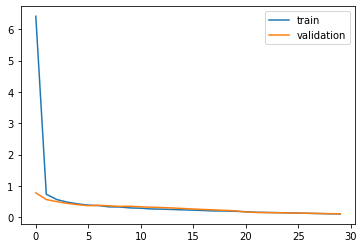

In [ ]:
#show value loss in the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
#define the second model
def embed_model(ms_length, en_vocab_size, ms_vocab_size, learning_rate=0.1):
    #Implement
    model = Sequential()
    model.add(Embedding(max(en_vocab_size, ms_vocab_size) ,128 , input_length=ms_length))
    #model.add(GRU(128, dropout=0.1, return_sequences=True))
    #layer 3 commited to reduce training time
    model.add(LSTM(128, dropout=0.1, return_sequences=True))
    model.add(Dense(ms_vocab_size, activation='softmax'))
    
    print('###### Summary ######')
    model.summary()
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model


#Train the neural network
embed_rnn_model = embed_model(
    ms_length,
    len(en_tokenizer.word_index)+1,
    len(ms_tokenizer.word_index)+1)

#Fitting model
m2 = embed_rnn_model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2)

###### Summary ######
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 128)           460032    
                                                                 
 lstm_2 (LSTM)               (None, 70, 128)           131584    
                                                                 
 dense_2 (Dense)             (None, 70, 3594)          463626    
                                                                 
Total params: 1,055,242
Trainable params: 1,055,242
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 4s 402ms/step - loss: 2.6100 - accuracy: 0.6878 - val_loss: 0.1547 - val_accuracy: 0.9880
Epoch 2/30
4/4 [==============================] - 1s 194ms/step - loss: 0.1803 - accuracy: 0.9888 - val_loss: 0.1402 - val_accuracy: 0.9903
Epoch 

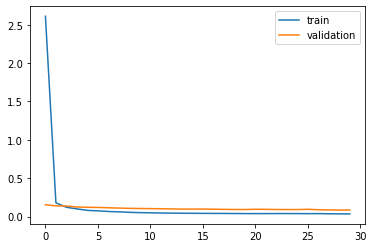

Train accurancy:  0.9918609261512756


In [ ]:
#show the second model value loss in the second model
plt.plot(m2.history['loss'])
plt.plot(m2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

score = embed_rnn_model.evaluate(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), verbose=0)
print("Train accurancy: ", score[1])